In [14]:
from main import *
from utils import *
from models import *
from torch.utils.data import DataLoader
from torch.nn.functional import softmax
from tqdm import tqdm

In [2]:
import os

In [25]:
tk_save_path = os.path.join('../checkpoints/hybrid', 'tokenizer.pkl')
model_save_path = os.path.join('../checkpoints/hybrid', 'hybrid.ckpt')
data_dir = '../data/splits'
device = torch.device('cuda')
batch_size = 16

In [26]:
with open(tk_save_path, 'rb') as f:
    tokenizer = pickle.load(f)
label_list = [tokenizer.id2label[i] for i in range(len(tokenizer.id2label))]


model = ConvClassifier.load_model(model_save_path).to(device)

In [27]:
TK_PAD_IDX = tokenizer.word_vocab[tokenizer.pad_token]
CHAR_PAD_IDX = tokenizer.char_vocab[tokenizer.pad_token]

In [28]:
dev_dataset = preprocess_data(data_dir, 'dev', tokenizer)
test_dataset = preprocess_data(data_dir, 'test', tokenizer)

In [29]:
import pandas as pd

In [30]:
def pad_batch(batch_samples):
    tk_ids, char_ids, labels = zip(*batch_samples)
    tk_lens = torch.LongTensor([len(tk) for tk in tk_ids])
    char_lens = torch.LongTensor([len(c) for c in char_ids])
    padded_tkids = pad_sequence(tk_ids, batch_first=True, padding_value=TK_PAD_IDX)
    padded_chars = pad_sequence(char_ids, batch_first=True, padding_value=CHAR_PAD_IDX)
    labels = torch.LongTensor(labels)
    return padded_tkids, tk_lens, padded_chars, char_lens, labels

def collect_logits(model, dataset):
    predictions = []
    ground_truth = []
    all_logits = []
    running_loss = 0.0

    dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=pad_batch)
    model.eval()
    for batch in tqdm(dataloader):

        batch = (t.to(device) for t in batch)
        tk_ids, tk_lens, char_ids, char_lens, labels = batch
        loss, logits = model.get_loss(tk_ids, tk_lens, char_ids, char_lens, labels)

        predictions.extend(logits.argmax(dim=1).tolist())
        ground_truth.extend(labels.tolist())
        all_logits.extend(softmax(logits, dim=1).tolist())
        running_loss += loss.item()

    running_loss /= len(dataloader)

    return predictions, ground_truth, all_logits

In [31]:
predictions, ground_truth, logits = collect_logits(model, dev_dataset)

100%|██████████| 530/530 [00:04<00:00, 106.28it/s]


In [42]:
samples = [tokenizer.decode_chars(sample[1].tolist()) for sample in dev_dataset]

In [34]:
label_list

['location', 'products', 'date', 'random_string', 'other', 'company']

In [44]:
df = pd.DataFrame({'samples':samples, 'predictions': predictions, 'ground_truth': ground_truth, 'logits': logits})

In [51]:
len(df[df['ground_truth']==0][df['predictions']==3][['samples', 'logits']])

<ipython-input-51-928a05a268ee>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df[df['ground_truth']==0][df['predictions']==3][['samples', 'logits']])


29

In [52]:
df[df['ground_truth']==0][df['predictions']==3][['samples', 'logits']]

<ipython-input-52-442a35ed50c5>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['ground_truth']==0][df['predictions']==3][['samples', 'logits']]


,samples,logits
34,badghis,"[0.1624574214220047, 0.00011443939001765102, 3..."
38,qods,"[0.392048180103302, 0.0036011526826769114, 5.0..."
62,vestfirir,"[0.3006434738636017, 0.0049293567426502705, 0...."
113,woleu-ntem,"[0.4072619080543518, 0.0030445565935224295, 1...."
114,gaoyao,"[0.4618729054927826, 0.00947509240359068, 0.00..."
117,kuks,"[0.12970134615898132, 0.006527287885546684, 1...."
128,falkirk,"[0.3755565583705902, 0.02040880173444748, 0.00..."
141,salzburg,"[0.025234609842300415, 2.9056857329123886e-06,..."
162,duisburg,"[0.3976680636405945, 0.00014818357885815203, 9..."
203,gifu,"[0.23873232305049896, 0.0010837960289791226, 9..."


In [61]:
import unidecode

In [66]:
with open('../data/loc_cities.txt') as f:
    cities = f.read().strip().split('\n')
with open('../data/loc_provinces.txt') as f:
    provinces = f.read().strip().split('\n')
with open('../data/loc_countries.txt') as f:
    countries = f.read().strip().split('\n')

cities = [unidecode.unidecode(city.strip()).lower() for city in cities]
provinces = [unidecode.unidecode(province.strip()).lower() for province in provinces]
countries = [unidecode.unidecode(country.strip()).lower() for country in countries]

locations = set()
locations.update(cities)
locations.update(provinces)
locations.update(countries)

In [97]:
def intervention(model, dataset, locations):
    predictions = []
    ground_truth = []
    all_logits = []
    running_loss = 0.0

    
    model.eval()
    for batch in tqdm(dataset):

        batch = (t.to(device) for t in batch)
        tk_ids, char_ids, labels = batch
        tk_ids = tk_ids.unsqueeze(0).to(device)
        
        if char_ids.size()[0] < 4:
            char_ids = torch.LongTensor(char_ids.tolist() + [tokenizer.char_vocab[tokenizer.pad_token]]*(4-char_ids.size()[0]))
        char_ids = char_ids.unsqueeze(0).to(device)
        
        tk_lens = torch.LongTensor([tk_ids.size()[1]]).to(device)
        char_lens = torch.LongTensor([char_ids.size()[1]]).to(device)
        #print(tk_ids.size(), char_ids.size())
        
        logits = model(tk_ids, tk_lens, char_ids, char_lens)

        cur_predictions = logits.argmax(dim=1).tolist()
        cur_labels = labels.item()
        cur_logits = softmax(logits, dim=1).tolist()

        if cur_predictions[0]==label_list.index('random_string'):
            cur_sample = tokenizer.decode_chars(char_ids.tolist()[0])
            if cur_sample in locations:
                cur_predictions[0]=label_list.index('location')
        
        predictions.extend(cur_predictions)
        ground_truth.append(cur_labels)
        all_logits.extend(cur_logits)

    return predictions, ground_truth, all_logits

In [98]:
predictions, ground_truth, all_logits = intervention(model, test_dataset, locations)

100%|██████████| 8478/8478 [00:17<00:00, 489.15it/s]


In [100]:
from sklearn.metrics import classification_report, confusion_matrix

In [99]:
print(classification_report(ground_truth, predictions))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       878
           1       0.93      0.95      0.94       596
           2       0.99      0.99      0.99      2000
           3       0.99      0.98      0.98      2000
           4       0.98      0.96      0.97      1004
           5       0.97      0.96      0.96      2000

    accuracy                           0.97      8478
   macro avg       0.96      0.96      0.96      8478
weighted avg       0.97      0.97      0.97      8478



In [104]:
cmatrix = confusion_matrix(ground_truth, predictions, normalize='true')*100

In [103]:
import seaborn as sn

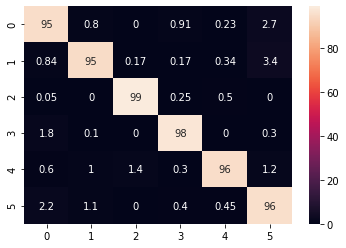

In [105]:
sn.heatmap(cmatrix, annot=True)